<a href="https://colab.research.google.com/github/jardilam/TalentoTech/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

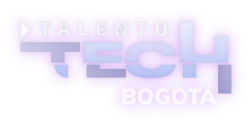

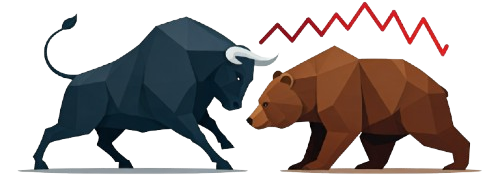

# Importamos las librerias a utilizar

In [11]:
!pip install pmdarima
!pip install seasonal

In [12]:
import yfinance as yf
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import numpy as np
import plotly.graph_objects as go

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import auto_arima
from seasonal import seasonal
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression


In [13]:
acciones = ["AAPL", "MSFT", "GOOG", "NVDA"]
#acciones = ["AAPL"]
inicio = "2005-01-01"
fin = datetime.today().strftime('%Y-%m-%d') #Establecemos como fecha de final para descargar los datos a la fecha de hoy.

# Descargar datos históricos
datos_historicos = []
consolidado_acciones = []
hist_por_accion = []

for accion in acciones:
    hist_por_accion = yf.download(accion, start=inicio, end=fin)
    hist_por_accion.columns = hist_por_accion.columns.get_level_values('Price')# Nos quedamos con las columnas del nivel Price de los 2 niveles de los datos obtenidos
    #hist_por_accion.columns = ["_".join(col).strip() if isinstance(col, tuple) else col for col in hist_por_accion.columns] #Esta línea convierte el MultiIndex en nombres de columna de una sola línea
    hist_por_accion = hist_por_accion.reset_index()  # Restablece el índice
    hist_por_accion["Simbolo"] = accion #Incluimos la columna acción
    datos_historicos.append(hist_por_accion)

consolidado_acciones = pd.concat(datos_historicos, ignore_index=True)
consolidado_acciones = pd.DataFrame(consolidado_acciones)
consolidado_acciones['Date'] = pd.to_datetime(consolidado_acciones['Date']).dt.date # Nos quedamos con el formato año-mes-día
consolidado_acciones['Date'] = pd.to_datetime(consolidado_acciones['Date'])

#Segmentamos el dataframe por trimestres, mes y semana
consolidado_acciones["Año"] = pd.DatetimeIndex(consolidado_acciones['Date']).year
consolidado_acciones["Trim"] = pd.DatetimeIndex(consolidado_acciones['Date']).quarter
consolidado_acciones["Mes"] = pd.DatetimeIndex(consolidado_acciones['Date']).month

# Renombramos las columnas
consolidado_acciones = consolidado_acciones.rename(columns={
    'Date': 'Fecha',
    'Open': 'Apertura',
    'High': 'Máximo',
    'Low': 'Mínimo',
    'Close': 'Cierre',
    'Adj Close': 'Cierre Ajustado',
    'Volume': 'Volumen'
})

consolidado_acciones = consolidado_acciones.set_index('Fecha')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
# Exploración Inicial:
print("Primeras filas del DataFrame:")
print(consolidado_acciones.head(2))
print(':'*80)
print("Últimas filas del DataFrame:")
print(consolidado_acciones.tail(2))
print(':'*80)
print("Información general de las columnas:")
print(consolidado_acciones.info())
print(':'*80)
print("Resumen estadístico de las columnas:")
print(consolidado_acciones.describe())
print(':'*80)

Primeras filas del DataFrame:
Price       Cierre Ajustado    Cierre    Máximo    Mínimo  Apertura  \
Fecha                                                                 
2005-01-03         0.953359  1.130179  1.162679  1.117857  1.156786   
2005-01-04         0.963150  1.141786  1.169107  1.124464  1.139107   

Price          Volumen Simbolo   Año  Trim  Mes  
Fecha                                            
2005-01-03   691992000    AAPL  2005     1    1  
2005-01-04  1096810400    AAPL  2005     1    1  
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Últimas filas del DataFrame:
Price       Cierre Ajustado      Cierre      Máximo      Mínimo    Apertura  \
Fecha                                                                         
2024-11-11       145.259995  145.259995  148.850006  143.570007  148.679993   
2024-11-12       148.289993  148.289993  149.649994  146.009995  146.779999   

Price         Volumen Simbolo   Año  Trim  Mes  
Fecha    

In [15]:
# Visualizamos el historico de precios
fig = px.line(consolidado_acciones, x=consolidado_acciones.index, y="Cierre Ajustado", color="Simbolo", title='Precio de Cierre de Acciones',template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre ajustado')
fig.show()

In [16]:
#Opciona para ver el compartamiento de la serie de tiempo de forma mensual o trimestral
consolidado_acciones['Fecha2'] = consolidado_acciones.index #creamos una copia de fecha para usarla en estas graficas
consolidado_acciones['Cierre ajustado mensual'] = consolidado_acciones.groupby(['Simbolo', pd.Grouper(key='Fecha2', freq='MS')])['Cierre Ajustado'].transform('last')
consolidado_acciones['Cierre ajustado trimestral'] = consolidado_acciones.groupby(['Simbolo', pd.Grouper(key='Fecha2', freq='QS')])['Cierre Ajustado'].transform('last')

consolidado_acciones_mensual = consolidado_acciones[['Fecha2','Simbolo','Cierre ajustado mensual']].drop_duplicates()
consolidado_acciones_mensual = consolidado_acciones_mensual.sort_values(['Simbolo','Fecha2'])

consolidado_acciones_trimestral = consolidado_acciones[['Fecha2','Simbolo','Cierre ajustado trimestral']].drop_duplicates()
consolidado_acciones_trimestral = consolidado_acciones_trimestral.sort_values(['Simbolo','Fecha2'])

# Visualizamos el historico de precios mensual
fig = px.line(consolidado_acciones_mensual, x=consolidado_acciones.index, y="Cierre ajustado mensual", color="Simbolo", title='Precio de Cierre de Acciones Ajustado Mensual',template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre ajustado mensual')
fig.show()

fig1 = px.line(consolidado_acciones_trimestral, x=consolidado_acciones.index, y="Cierre ajustado trimestral", color="Simbolo", title='Precio de Cierre de Acciones Ajustado trimestral',template='plotly_dark')
fig1.update_xaxes(title_text='Fecha')
fig1.update_yaxes(title_text='Precio de Cierre ajustado trimestral')
fig1.show()

consolidado_acciones = consolidado_acciones.drop(columns=['Fecha2']) #Eliminamos la columna creada para esta visual


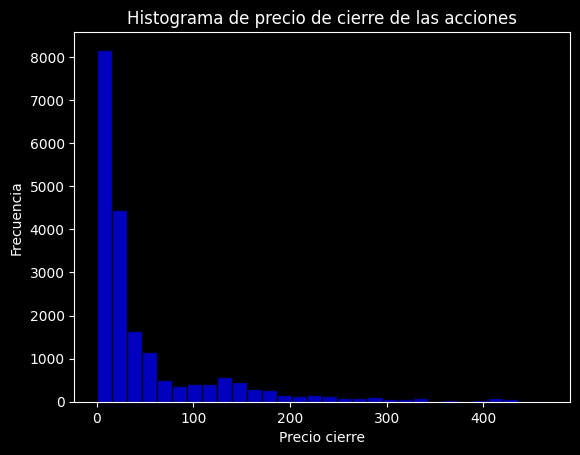

In [17]:
# Realización histograma de la frecuencia del precio de cierre:
plt.style.use("dark_background")
plt.hist(consolidado_acciones["Cierre Ajustado"], bins=30, alpha=0.75, color="blue", edgecolor="black")
plt.title("Histograma de precio de cierre de las acciones")
plt.xlabel("Precio cierre")
plt.ylabel("Frecuencia")
plt.show()

In [18]:
#Creamos el histograma para cada acción
fig = make_subplots(rows=2, cols=2, subplot_titles=acciones)

for i, accion in enumerate(acciones):
    row = i // 2 + 1
    col = i % 2 + 1
    hist_data1 = consolidado_acciones[consolidado_acciones["Simbolo"] == accion]["Cierre Ajustado"].dropna()
    hist_data2 = consolidado_acciones[consolidado_acciones["Simbolo"] == accion].index
    fig.add_trace(
        go.Histogram(x=hist_data1, y=hist_data2, name=accion),
        row=row, col=col
    )

fig.update_layout(title_text="Histograma de Precios de Cierre Ajustados para las Acciones", template="plotly_dark")

fig.show()

In [19]:
# Realización el gráfico de dispersión
fig = make_subplots(rows=2, cols=2, subplot_titles=acciones)

for i, accion in enumerate(acciones):
    row = i // 2 + 1
    col = i % 2 + 1
    scatter_data = consolidado_acciones[consolidado_acciones["Simbolo"] == accion]
    fig.add_trace(
        go.Scatter(x=scatter_data.index, y=scatter_data["Cierre Ajustado"], mode="markers", name=accion),
        row=row, col=col
    )

fig.update_layout(title_text="Gráfico de Dispersión de Precios de Cierre Ajustados para las Acciones", template="plotly_dark")

fig.show()

Error cuadrático medio (MSE): 999.5881777263356
Coeficiente de Determinación (R^2): 0.7309854164977092


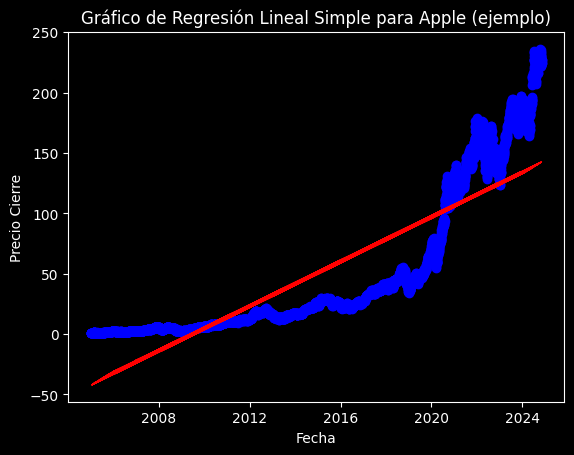

In [20]:
apple = consolidado_acciones[consolidado_acciones["Simbolo"] == "AAPL"]
apple = apple.reset_index()
apple = apple[["Fecha", "Cierre Ajustado"]]

apple["Año"] = apple["Fecha"].dt.year
apple["Mes"] = apple["Fecha"].dt.month
apple["Día"] = apple["Fecha"].dt.day

X = apple[["Año", "Mes", "Día"]]
y = apple["Cierre Ajustado"]

# División de los datos en conjuntos de entrenamiento y prueba con una relación de 80/20:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creación del modelo de regresión lineal y entrenamiento
modelo = LinearRegression().fit(X_train, y_train)

y_pred = modelo.predict(X_test) # realizamos las predicciones

# Evaluando el modelo:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R^2): {r2}")

# Visualización de los datos y la línea de regresión:
plt.scatter(apple["Fecha"], y, color="blue", label="Datos Reales")
plt.plot(apple.loc[X_test.index]["Fecha"], y_pred, color="red", linewidth=1, label="Predicciones")
plt.title("Gráfico de Regresión Lineal Simple para Apple (ejemplo)")
plt.xlabel("Fecha")
plt.ylabel("Precio Cierre")
plt.show()

In [21]:
# Aplicamos la prueba de ADF sobre la serie logarítmica para cada acción
for accion in acciones:
    print(f"Prueba Dickey-Fuller ADF para la acción {accion} en Serie Logarítmica:")

    # Filtrar los datos para cada acción
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]

    # Calcular el logaritmo del precio de cierre
    serie_log = np.log(datos_accion['Cierre Ajustado'])

    # Aplicar la prueba ADF en la serie logarítmica
    resultado_adf_log = adfuller(serie_log.dropna())

    # Imprimir los resultados
    print(f"Estadístico ADF: {resultado_adf_log[0]}")
    P_valor = 0.05
    if resultado_adf_log[1] <= P_valor:
        print("Se rechaza la hipótesis nula. La serie es estacionaria.")
    else:
        print("No se rechaza la hipótesis nula. La serie no es estacionaria.")
    print(f"p-valor: {resultado_adf_log[1]}")
    print(":" * 80)

Prueba Dickey-Fuller ADF para la acción AAPL en Serie Logarítmica:
Estadístico ADF: -1.2013779431589944
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.6730026748563457
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción MSFT en Serie Logarítmica:
Estadístico ADF: 1.0437725539754361
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.9947069866381378
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción GOOG en Serie Logarítmica:
Estadístico ADF: -0.7534581447083596
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.832412720990543
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción NVDA en Serie Logarítmica:
Estadístico ADF: 1.2471807621372788
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.9

In [22]:
# Realizmaos ADF sobre la serie logarítmica diferenciada para cada acción
for accion in acciones:
    print(f"Prueba Dickey-Fuller ADF para la acción {accion} en Serie Logarítmica Diferenciada:")

    # Filtrar los datos para cada acción
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]

    # Calcular el logaritmo del precio de cierre Ajustado
    serie_log = np.log(datos_accion['Cierre Ajustado'])

    # Diferenciación de la serie logarítmica (primer diferencia)
    serie_log_diff = serie_log.diff().dropna()

    # Aplicar la prueba ADF en la serie logarítmica diferenciada
    resultado_adf_log_diff = adfuller(serie_log_diff)

    # Imprimir los resultados
    print(f"Estadístico ADF: {resultado_adf_log_diff[0]}")
    P_valor = 0.05
    if resultado_adf_log_diff[1] <= P_valor:
        print("Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.")
    else:
        print("No se rechaza la hipótesis nula para el diferencial. La serie no es estacionaria.")
    print(f"p-valor: {resultado_adf_log_diff[1]}")
    print(":" * 80)

Prueba Dickey-Fuller ADF para la acción AAPL en Serie Logarítmica Diferenciada:
Estadístico ADF: -16.68963898431396
Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.
p-valor: 1.4922872043273228e-29
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción MSFT en Serie Logarítmica Diferenciada:
Estadístico ADF: -25.46848461549465
Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.
p-valor: 0.0
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción GOOG en Serie Logarítmica Diferenciada:
Estadístico ADF: -72.74399315933375
Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.
p-valor: 0.0
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción NVDA en Serie Logarítmica Diferenciada:
Estadístico ADF: -14.245798620597634
Se rec

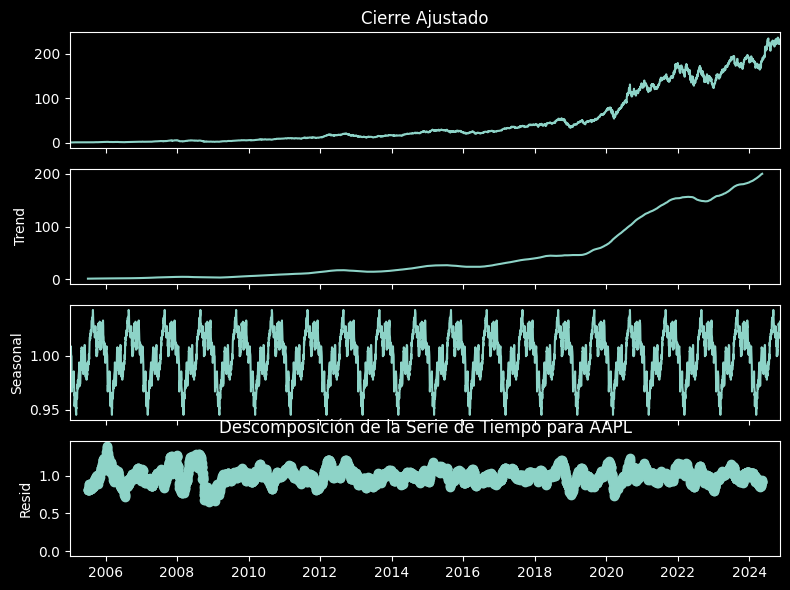

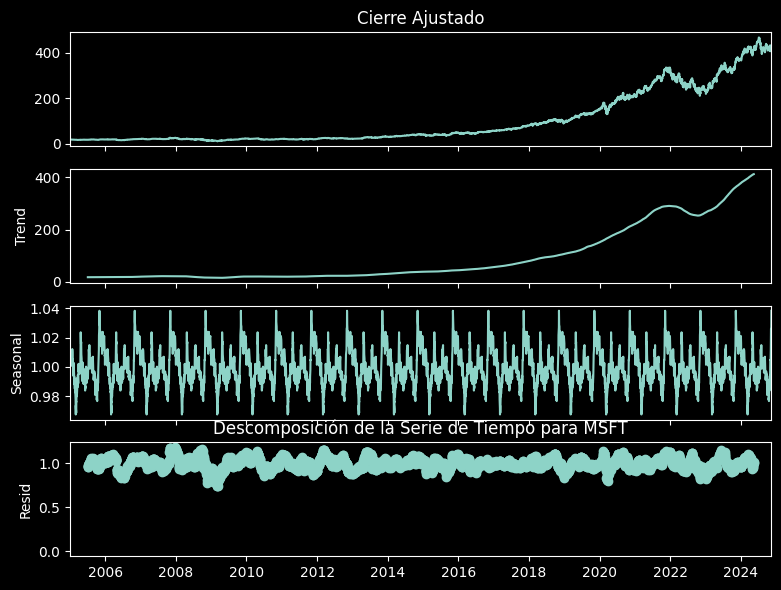

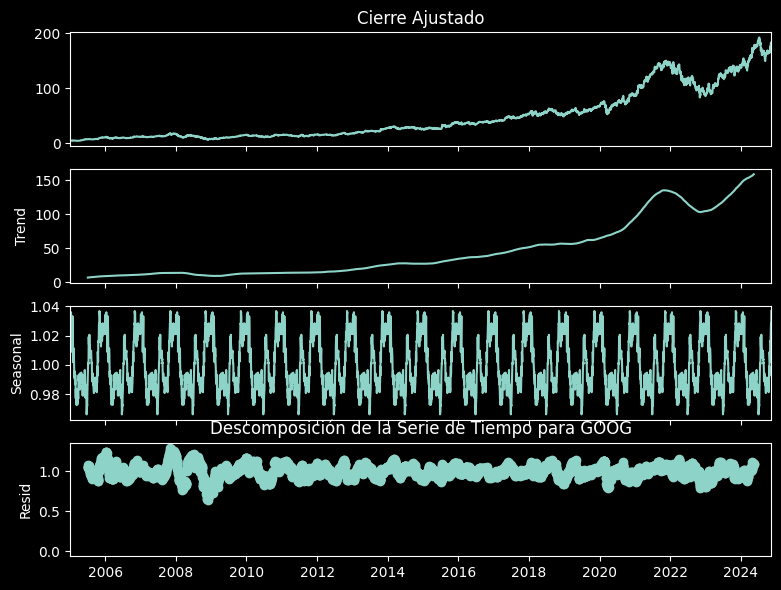

In [23]:
# Descomposición de la serie de tiempo para cada acción

for accion in acciones:
  datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]['Cierre Ajustado']
  result = seasonal_decompose(datos_accion, model='mul', period=252) # Días hábiles

  # Graficar la descomposición
  plt.rcParams.update({'figure.figsize': (8, 6)})
  result.plot()
  plt.title(f"Descomposición de la Serie de Tiempo para {accion}")  # Agregar título con el nombre de la acción
  plt.show()

In [24]:
#Definimos las función para obtener los componentes para las acciones para gráfica en power bi
#Inicio--->
def obtener_componentes_series_tiempo(df):
  df_componentes = pd.DataFrame()
  for accion in df['Simbolo'].unique():
    df_accion = df[df['Simbolo'] == accion].copy()
    # Descomponemos de la serie de tiempo
    result = seasonal_decompose(df_accion['Cierre Ajustado'], model='mul', period=252) # Días hábiles
    df_accion['Tendencia'] = result.trend #Obtenemos los valores de tendencia.
    df_accion['Estacionalidad'] = result.seasonal #Obtenemos los valores de estacionalidad
    df_accion['Residuo'] = result.resid #Obtenemos los valores de estacionalidad
    df_componentes = pd.concat([df_componentes, df_accion])#Concatemas cada componente obtenida
  return df_componentes
#Integramos los valores de las componentes al dataframde de trabajo
consolidado_acciones = obtener_componentes_series_tiempo(consolidado_acciones)
#---> Fin

In [25]:
#Evaluación de modelos

import numpy as np
from sklearn import metrics
from sklearn.metrics import r2_score
def evaluacion_modelo(y_true, y_pred):

    def men_abs_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) *100
    #print('Evaluación del modelo: \n')
    print('MSE = ', metrics.mean_squared_error(y_true, y_pred))
    print('MAE = ', metrics.mean_absolute_error(y_true, y_pred))
    print('RMSE =', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('MAPE = ', men_abs_percentage_error(y_true, y_pred))
    print(f'R2 = {r2_score(y_true, y_pred)}')

# **Modelos de predicción**

In [26]:
#Preparamos los datos de prueba y entrenamiento apartir del index (fecha)
train_data = consolidado_acciones.sort_index().loc[:'2023-12-31']
train_data = len(train_data.index.unique())

test_data = consolidado_acciones.sort_index().loc['2023-12-31':]
test_data = len(test_data.index.unique())

total_data = train_data + test_data

test_size = test_data/total_data

train_data, test_data, total_data, test_size

(4781, 219, 5000, 0.0438)

## Modelo SARIMAX

In [27]:
from statsmodels.tsa.stattools import adfuller

resultados_sarimax_por_accion = {}
añadir_resultados_sarimax_por_accion =[]
Resultados_SA = {}

#acciones = ["AAPL","MSFT","GOOG","NVDA"]


for accion in acciones:
    print(f"Ajustando modelo SARIMAX para la acción: {accion}")
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]
    datos_accion = datos_accion['Cierre Ajustado']

    train_data_SA, test_data_SA = train_test_split(datos_accion, test_size=test_size, random_state=42, shuffle=False) #Aseguramos que la división de los datos se realice de forma secuencial.
    train_data_SA = pd.DataFrame(train_data_SA)
    test_data_SA = pd.DataFrame(test_data_SA)

#Ejecutamos auto_arima para que el modelo calcule los datos p,d,q y P,D,Q
    modelo_auto = pm.auto_arima(train_data_SA, start_p=0, q=0,
                          test='adf',       # Ajusta el mejor valor para d aplicando la prueba Augmented Dickey Fuller
                          max_p=3, max_q=3, # maximos valores para p y q
                          m=252,                          # Días hábiles
                          d=None,                         # El modelo determina el valor de d
                          seasonal=False,                 # Serie de tiempo no estacional de acuerdo con la prueba ADF
                          start_P=0, start_Q=0,           # Iniciar en 0 para la estacionalidad
                          max_P=2, max_Q=2,               # Límite en el orden AR y MA estacionales
                          D=1,                            # Diferenciación estacional
                          max_order=10,                   # Límite en el orden total
                          stepwise=True,                  # Búsqueda rápida en lugar de exhaustiva
                          error_action="ignore",          # Ignorar errores menores
                          suppress_warnings=True,         # Suprimir advertencias
                          trace=False)                    # Mostrar detalles del ajuste

    # Obtener los mejores parámetros del modelo
    order = modelo_auto.order
    seasonal_order = modelo_auto.seasonal_order

    # Ajustar el modelo con los mejores parámetros
    sarimax_model = SARIMAX(train_data_SA, order=order, seasonal_order=seasonal_order).fit()

    #Realizamos las predicciones
    resultados_sarimax_por_accion = sarimax_model.predict(start = len(train_data_SA), end = len(datos_accion)-1, typ='levels').rename('SA_predicción')
    resultados_sarimax_por_accion = pd.DataFrame(resultados_sarimax_por_accion)

    mse = mean_squared_error(test_data_SA, resultados_sarimax_por_accion )
    r2 = r2_score(test_data_SA, resultados_sarimax_por_accion )
    print(f"Error cuadrático medio (MSE): {mse}")
    print(f"Coeficiente de Determinación (R^2): {r2}")

    resultados_sarimax_por_accion['Simbolo'] = accion
    resultados_sarimax_por_accion.index = test_data_SA.index
    añadir_resultados_sarimax_por_accion.append(resultados_sarimax_por_accion)




Resultados_SA = pd.concat(añadir_resultados_sarimax_por_accion)
Resultados_SA = pd.DataFrame(Resultados_SA)


Ajustando modelo SARIMAX para la acción: AAPL


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (252) set for non-seasonal fit. Setting to 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result i

Error cuadrático medio (MSE): 618.902386511008
Coeficiente de Determinación (R^2): -0.18564453829220273
Ajustando modelo SARIMAX para la acción: MSFT


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/d

Error cuadrático medio (MSE): 2227.4942255713536
Coeficiente de Determinación (R^2): -5.8312831663449005
Ajustando modelo SARIMAX para la acción: GOOG


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (252) set for non-seasonal fit. Setting to 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result i

Error cuadrático medio (MSE): 697.0843369285689
Coeficiente de Determinación (R^2): -2.3939907355493966
Ajustando modelo SARIMAX para la acción: NVDA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Error cuadrático medio (MSE): 3536.2767395076157
Coeficiente de Determinación (R^2): -4.344992555716547


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [28]:
Resultados = Resultados_SA.copy()
Resultados['Real']=test_data_SA['Cierre Ajustado']
Resultados = Resultados[['Simbolo', 'Real', 'SA_predicción']] #Reordenamos

In [29]:
# Graficamos las predicción y los valores reales
fig = px.line(Resultados, x=Resultados.index, y=['Real', 'SA_predicción'], color='Simbolo',
             title='Comparación de Predicciones SARIMAX vs. Valores Reales',
             labels={'value': 'Precio de Cierre Ajustado', 'variable': 'Tipo de Datos'},
             template='plotly_dark')

fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio (USD)')
fig.show()

## Modelo PROPHET

In [30]:
# Creamos un diccionario para almacenar los resultados de Prophet por acción
resultados_prophet_por_accion = {}
test_data_prophet_all = {} # Add a dictionary to store all test data

fecha_actual = datetime.today()


# Iterar sobre las acciones
for accion in acciones:
    print(f"Ajustando modelo Prophet para la acción: {accion}")
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion][['Cierre Ajustado']].copy()
    datos_accion.reset_index(inplace=True)
    datos_accion = datos_accion.rename(columns={'Fecha': 'ds', 'Cierre Ajustado': 'y'})

    # Dividir los datos en entrenamiento y prueba
    train_data_prophet, test_data_prophet = train_test_split(datos_accion, test_size=test_size, random_state=42, shuffle=False)
    test_data_prophet_all[accion] = test_data_prophet # Store the test data for each stock

    # Crear y entrenar el modelo Prophet
    modelo_prophet = Prophet()
    modelo_prophet.fit(train_data_prophet)

    # Crear un DataFrame con las fechas futuras para predecir
    future = modelo_prophet.make_future_dataframe(periods=len(test_data_prophet),freq='B') # Frecuencia para días hábiles

    # Realizar la predicción
    forecast = modelo_prophet.predict(future)

    forecast['ds'] = pd.to_datetime(forecast['ds'])  # Asegurarse de que la columna ds esté en formato datetime
    forecast_filtrado = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= fecha_actual)]

    # Guardar los resultados en el diccionario
    resultados_prophet_por_accion[accion] = forecast_filtrado[['ds', 'yhat']]#Seleccionamos las columnas de interes

    print(":"*80)
    print(f"Evaluación de la predicción para {accion}")
    mse = mean_squared_error(test_data_prophet['y'], forecast_filtrado['yhat'])
    r2 = r2_score(test_data_prophet['y'], forecast_filtrado['yhat'])
    print(f"Error cuadrático medio (MSE): {mse}")
    print(f"Coeficiente de Determinación (R^2): {r2}\n")
    print(":"*80)

    resultados_prophet_por_accion[accion]['Simbolo'] = accion
    resultados_prophet_por_accion[accion] = resultados_prophet_por_accion[accion].rename(columns={'ds': 'Fecha', 'yhat': 'PP_predicción'})
    resultados_prophet_por_accion[accion] = resultados_prophet_por_accion[accion].set_index('Fecha')

# Concatenar los resultados de todas las acciones
Resultados_Prophet = pd.concat(resultados_prophet_por_accion.values())
Resultados_Prophet = pd.DataFrame(Resultados_Prophet)

# Unir los resultados de Prophet con los datos reales
Resultados_finales_Prophet = Resultados_Prophet.copy()
# Create a list to store real values for all stocks
all_real_values = []

# Iterate through each stock and extract real values
for accion in acciones:
    # Get the test data for the current stock
    test_data_prophet = test_data_prophet_all[accion]
    # Append the real values to the list
    all_real_values.extend(test_data_prophet['y'].values)

# Assign the real values to the 'Real' column
Resultados_finales_Prophet['Real'] = all_real_values
Resultados_finales_Prophet = Resultados_finales_Prophet[['Simbolo', 'Real', 'PP_predicción']]

# Graficar las predicciones de Prophet
fig = px.line(Resultados_finales_Prophet, x=Resultados_finales_Prophet.index, y=['Real', 'PP_predicción'], color='Simbolo',
             title='Comparación de Predicciones Prophet vs. Valores Reales',
             labels={'value': 'Precio de Cierre Ajustado', 'variable': 'Tipo de Datos'},
             template='plotly_dark')

fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio (USD)')
fig.show()


Ajustando modelo Prophet para la acción: AAPL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gl7crc1/qiptvjga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gl7crc1/70va4e0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30447', 'data', 'file=/tmp/tmp2gl7crc1/qiptvjga.json', 'init=/tmp/tmp2gl7crc1/70va4e0k.json', 'output', 'file=/tmp/tmp2gl7crc1/prophet_modelri2cxghj/prophet_model-20241113225451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-30-a11b00cf8ee4>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Evaluación de la predicción para AAPL
Error cuadrático medio (MSE): 297.1110905707019
Coeficiente de Determinación (R^2): 0.43081792948470543

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Ajustando modelo Prophet para la acción: MSFT


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gl7crc1/qfyeab2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73626', 'data', 'file=/tmp/tmp2gl7crc1/57bs8s13.json', 'init=/tmp/tmp2gl7crc1/qfyeab2p.json', 'output', 'file=/tmp/tmp2gl7crc1/prophet_modelil_ekn7f/prophet_model-20241113225455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-30-a11b00cf8ee4>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Evaluación de la predicción para MSFT
Error cuadrático medio (MSE): 4448.767626189489
Coeficiente de Determinación (R^2): -12.64348829590037

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Ajustando modelo Prophet para la acción: GOOG


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gl7crc1/d98ku5d8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62430', 'data', 'file=/tmp/tmp2gl7crc1/642p5ua4.json', 'init=/tmp/tmp2gl7crc1/d98ku5d8.json', 'output', 'file=/tmp/tmp2gl7crc1/prophet_modeliamg_m4t/prophet_model-20241113225458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-30-a11b00cf8ee4>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Evaluación de la predicción para GOOG
Error cuadrático medio (MSE): 531.1941686266935
Coeficiente de Determinación (R^2): -1.5862983739392265

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Ajustando modelo Prophet para la acción: NVDA


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gl7crc1/q200fwy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12557', 'data', 'file=/tmp/tmp2gl7crc1/6b91a8ji.json', 'init=/tmp/tmp2gl7crc1/q200fwy1.json', 'output', 'file=/tmp/tmp2gl7crc1/prophet_model_9qfpbw2/prophet_model-20241113225501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Evaluación de la predicción para NVDA
Error cuadrático medio (MSE): 4478.442622375744
Coeficiente de Determinación (R^2): -5.769052379405977

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


<ipython-input-30-a11b00cf8ee4>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# Reset the index of Resultados_finales_Prophet
Resultados_finales_Prophet1 = Resultados_finales_Prophet.reset_index()

# Reset the index of Resultados1
Resultados1 = Resultados.copy()
Resultados1 = Resultados1.reset_index()

# Merge Resultados_finales_Prophet with Resultados1 based on 'Simbolo' and 'Fecha'
Resultados1 = pd.merge(Resultados1, Resultados_finales_Prophet1[['Simbolo', 'Fecha', 'PP_predicción']], on=['Simbolo', 'Fecha'], how='left')

# Set the index back to 'Fecha' if desired
Resultados1 = Resultados1.set_index('Fecha')


In [32]:
# Graficamos las predicciones de Prophet y SARIMAX
fig = px.line(Resultados1, x=Resultados1.index, y=['Real', 'SA_predicción','PP_predicción'], color='Simbolo',
             title='Comparación de Predicciones Prophet vs. Valores Reales',
             labels={'value': 'Precio de Cierre Ajustado', 'variable': 'Tipo de Datos'},
             template='plotly_dark')

fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio (USD)')
fig.show()

# **Método de Monte-Carlo**

In [33]:
# Calculamos los rendimientos diarios para cada acción
consolidado_acciones['Rendimiento'] = consolidado_acciones.groupby('Simbolo')['Cierre Ajustado'].pct_change()

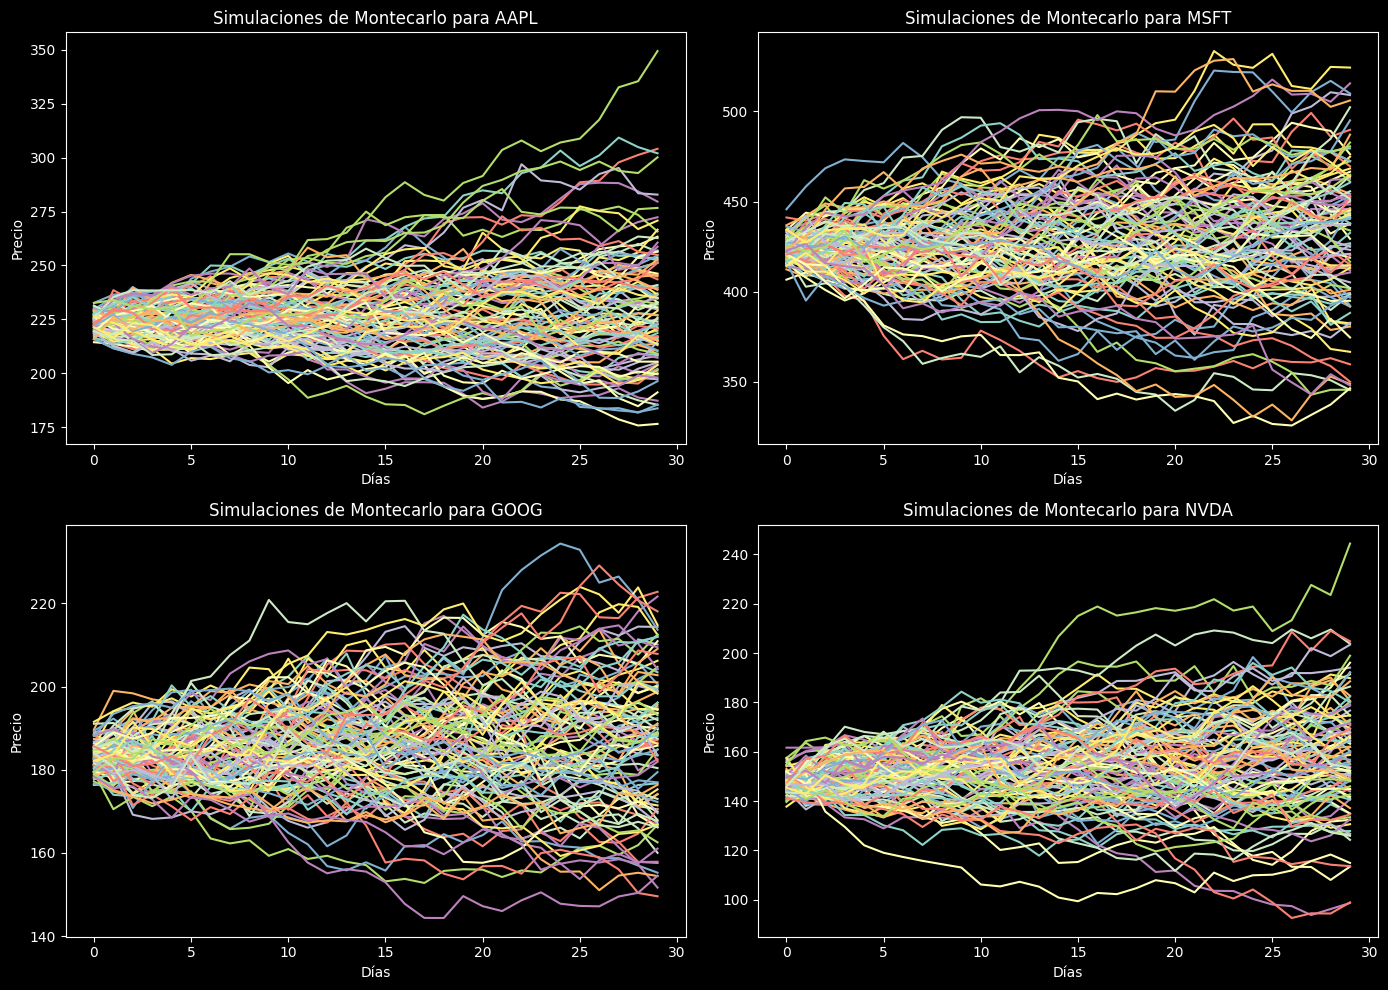

In [34]:
# Parámetros para la simulación
N_simulaciones = 100  # Número de simulaciones
N_dias = 30  # Número de días a simular

# Crear subplots 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Iterar sobre cada acción y cada subplot
for i, accion_a_simular in enumerate(acciones):
    # Filtrar los datos para la acción actual
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion_a_simular]

    # Extraer los rendimientos diarios
    rendimientos = datos_accion['Rendimiento'].dropna()

    # Último precio de cierre ajustado para iniciar las simulaciones
    ultimo_precio = datos_accion['Cierre Ajustado'].iloc[-1]

    # Iniciar las simulaciones
    simulaciones = np.zeros((N_dias, N_simulaciones))

    for j in range(N_simulaciones):
        # Generar cambios porcentuales aleatorios
        cambios_porcentuales = np.random.normal(rendimientos.mean(), rendimientos.std(), N_dias)
        # Simular los precios
        simulaciones[:, j] = ultimo_precio * (1 + cambios_porcentuales).cumprod()

    # Seleccionar el subplot adecuado
    ax = axs[i // 2, i % 2]  # Ubicación en la cuadrícula 2x2

    # Graficar las simulaciones en el subplot
    ax.plot(simulaciones)
    ax.set_title(f'Simulaciones de Montecarlo para {accion_a_simular}')
    ax.set_xlabel('Días')
    ax.set_ylabel('Precio')

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

# Evaluación de los modelos

In [35]:
Resultado_sin_na = Resultados1.dropna()
print("Evaluación del modelo SARIMAX")
ev_SA = evaluacion_modelo(Resultados1['Real'], Resultados1['SA_predicción'])

print("\nEvaluación del modelo PROPHET")
ev_PP = evaluacion_modelo(Resultado_sin_na['Real'], Resultado_sin_na['PP_predicción'])

Evaluación del modelo SARIMAX
MSE =  22015.74078265439
MAE =  112.59969500971145
RMSE = 148.37702242144633
MAPE =  121.66256286184651
R2 = -32.27623352471491

Evaluación del modelo PROPHET
MSE =  20041.08466512914
MAE =  113.32979368109639
RMSE = 141.56653794286677
MAPE =  122.54225114137583
R2 = -31.22373287752052


## WEB Scraping

Para ejecutar en entorno local

In [36]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Lista de símbolos de acciones
#acciones = ["AAPL", "MSFT", "GOOG", "NVDA"]

#Ruta de controlador de google chrome
chromedriver_path = r"C:\Users\jadom\OneDrive\Desktop\Curso Python\0. Drivers\d_Chrome.exe" # Modificar la ruta en donde este guardado su controlador del navegador

#Opciones para inciar google chrome
chrome_options = Options()
chrome_options.add_argument("--incognito")
#chrome_options.add_argument("--headless")

# Inicializamos el servicio de ChromeDriver
service = Service(chromedriver_path)

# Creamos una lista para almacenar los datos
ebitda = []

#Iteramos
for accion in acciones :
    Url = f"https://finance.yahoo.com/quote/{accion}/key-statistics/"

    try:
        # Inicializar el driver
        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver.get(Url)

        # Buscamos el elemento texto en la ruta indicado XPATH
        element_text = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, "/html/body/div[2]/main/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[5]/td[2]"))
        )

        #texto = element_text.text
        print(f"Texto extraído de {accion}: {texto}")

        # Agregar los datos a la lista
        ebitda.append({
            "Simbolo": accion,
            "Ebitda": texto
        })

    #Control de errores
    except Exception as e:
        print(f"Ocurrió un error con {accion}: {e}")

    finally:
        # Cerrar el navegador
        driver.quit()

# Crear un DataFrame con todos los datos
ebitda = pd.DataFrame(ebitda)

# Guardar los datos en un archivo CSV único
ebitda.to_csv("ebitda.csv", index=False)



ModuleNotFoundError: No module named 'selenium'